# Complex XY Model

See, for example:
- https://link.springer.com/article/10.1007%2FJHEP08%282010%29020

In [2]:
import numpy as np
import pandas as pd

from pystatplottools.pdf_env.loading_figure_mode import loading_figure_mode
fma, plt = loading_figure_mode(develop=True) # develop=False will export the generated figures as pngs into "./data/RectangleData"
plt.style.use('seaborn-dark-palette')

if 'root_dir' not in locals():
    # Navigate to examples/ComplexXYModel directory as simulation root directory
    import os
    os.chdir("../examples/ComplexXYModel")
    root_dir = os.getcwd()

# To be able to compute custom measures
import sys
sys.path.append("./../../python_scripts")
    
mcmc_model_dir = "ComplexXYModelComplexLangevin/"
mcmc_data_dir = root_dir + "/data/" + mcmc_model_dir
mcmc_results_dir = root_dir + "/results/" + mcmc_model_dir

data_dir = root_dir + "/data/" + mcmc_model_dir
results_dir = root_dir + "/results/" + mcmc_model_dir

## MCMC Results

### Expectation Values

In [3]:
from mcmctools.modes.expectation_value import load_expectation_value_results
expectation_values = load_expectation_value_results(files_dir="ComplexXYModelComplexLangevin")
# Insert Mu as column (as floating number)
expectation_values.insert(0, "Mu", expectation_values.index.values.astype(np.float))
expectation_values

Quantity,Mu,ExpVal,Error,ExpVal,Error
Observable,,Energy,Energy,Mean,Mean
mu,,,,,
0.000000,0.000000,-1.480165+0.000000j,0.000167+0.000000j,2.495662+0.000000j,0.003163+0.000000j
0.447214,0.447214,-1.571176-0.000033j,0.000211+0.000044j,4.183904+0.000000j,0.001234+0.000000j


## Configurations as Pytorch Dataset

We show how the mcmc configurations can be stored and loaded as a .pt file.

(See also python_scripts/loading_configurations.py and python_scripts/pytorch_data_generation.py)

### Preparation

In [4]:
data_generator_args = {
    # ConfigDataGenerator Args
    "data_type": "target_param",
    # Args for ConfigurationLoader
    "path": mcmc_data_dir,
    "total_number_of_data_per_file": 20000,
    "identifier": "expectation_value",
    "running_parameter": "mu",
    "chunksize": 100  # If no chunksize is given, all data is loaded at once
}

# Prepare in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import prepare_in_memory_dataset
from mcmctools.pytorch.data_generation.datagenerationroutines import data_generator_factory

prepare_in_memory_dataset(
    root=data_dir,
    batch_size=128,
    data_generator_args=data_generator_args,
    data_generator_name="BatchConfigDataGenerator",
    data_generator_factory=data_generator_factory
)

Random seed is set by np.random.seed()


### Generating and Loading the Dataset

In [5]:
# Load in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import load_in_memory_dataset

# The dataset is generated and stored as a .pt file in the data_dir/data directory the first time this function is called. Otherwise the .pt is loaded.
data_loader = load_in_memory_dataset(
    root=data_dir, batch_size=128, data_generator_factory=data_generator_factory, slices=None, shuffle=True,
    num_workers=0, rebuild=False
    # sample_data_generator_name="ConfigDataGenerator"  # optional: for a generation of new samples
)

# Load training data
for batch_idx, batch in enumerate(data_loader):
    data, target = batch
    # print(batch_idx, len(data))

Processing...
Random seed is set by np.random.seed()
Done!


### Inspection of the Dataset - Sample Visualization

In [18]:
from pystatplottools.visualization import sample_visualization

# Random samples
config, label = data_loader.dataset.get_random_sample()
batch, batch_label = data_loader.dataset.get_random_batch(108)

In [19]:
data[:, 1::2].min(), data[:, 1::2].max(), data[:, 0::2].min(), data[:, 0::2].max()

(tensor(-1.0760), tensor(1.6396), tensor(7.5000e-05), tensor(6.2832))

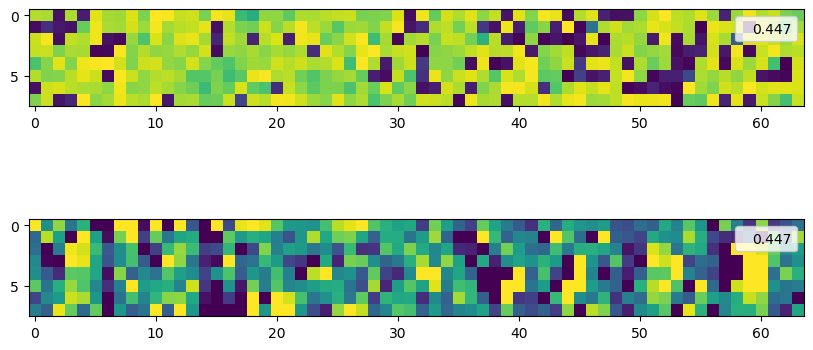

In [20]:
# Single Sample
fig, axes = fma.newfig(1, nrows=2, ratio=0.5, figsize=(10, 5))

# Real parts
sample_visualization.fd_im_single_sample(sample=config[0::2], label=label, config_dim=(8, 64), ab=(0, 2 * np.pi),
                                         fig=fig, ax=axes[0]);
# Imag parts
sample_visualization.fd_im_single_sample(sample=config[1::2], label=label, config_dim=(8, 64), num_std=1,
                                         fig=fig, ax=axes[1]);
fma.savefig(results_dir, "single_sample")

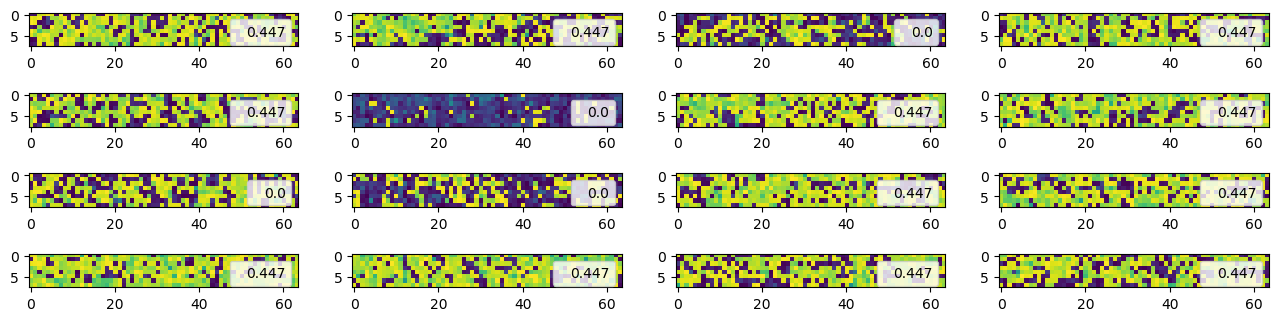

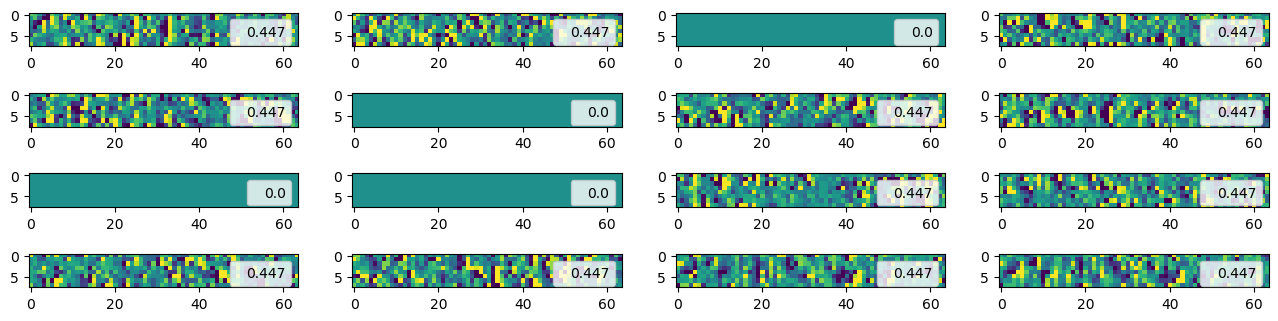

In [21]:
# Batch with labels
sample_visualization.fd_im_batch(batch[:, 0::2], batch_labels=batch_label, num_samples=16, dim=(4, 4),
                                 config_dim=(8, 64), ab=(0, 2 * np.pi),
                                 fma=fma, filename="batch_real_parts", directory=results_dir, width=2.3, ratio=1.0, figsize=(16, 4));

sample_visualization.fd_im_batch(batch[:, 1::2], batch_labels=batch_label, num_samples=16, dim=(4, 4),
                                 config_dim=(8, 64), num_std=1,
                                 fma=fma, filename="batch_imag_parts", directory=results_dir, width=2.3, ratio=1.0, figsize=(16, 4));

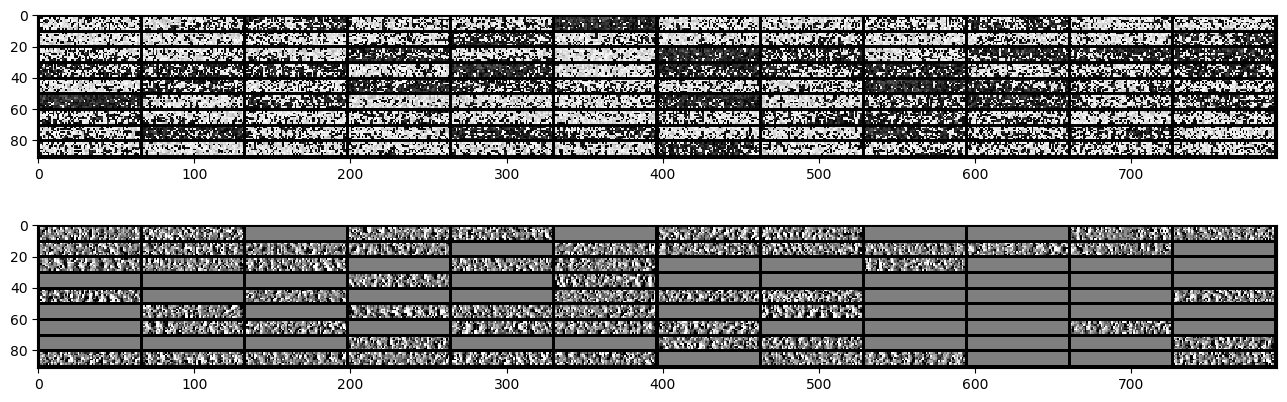

In [22]:
# Batch grid
fig, axes = fma.newfig(1, nrows=2, ratio=0.5, figsize=(16, 5))

# Real parts
sample_visualization.fd_im_batch_grid(batch[:, 0::2], config_dim=(8, 64), ab=(0, 2 * np.pi),
                                      fig=fig, ax=axes[0]);
# Imag parts
sample_visualization.fd_im_batch_grid(batch[:, 1::2], config_dim=(8, 64), num_std=1,
                                      fig=fig, ax=axes[1]);
fma.savefig(results_dir, "batch_grid")